<h1><center>LINMA2472 : Project 2 - part 2, Random Fourier Features </center></h1>

$\textbf{Author}$: Remi Delogne, remi.delogne@uclouvain.be

Import the following packages and functions. Refer to their documentation on the internet for more information on installation and usage.


In [1]:
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import accuracy_score

from keras.datasets import mnist #Contains the dataset
from matplotlib import pyplot

import time #Used to find the execution time of a part of the code

from IPython.display import display, HTML #For visual comfort
display(HTML("<style>.container { width:80% !important; }</style>"))

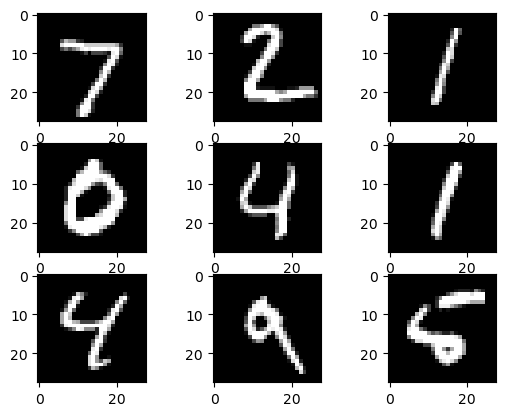

(10000, 784)


In [2]:
# load dataset and rescale the data to [0,15]
''' load dataset: (we use the larger subset for testing and the smaller 
for training to demonstrate the efficiency of evaluating of new instances with RFF)'''
(testX,testy),(trainX,trainy) = mnist.load_data()
#Rescaling
trainX = np.floor(trainX/16)
testX = np.floor(testX/16)

#Plot some images, for fun
for i in range(9):
    pyplot.subplot(330+1+i)
    pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

#Put the data in vector form
trainX=trainX.reshape((10000,-1))
testX=testX.reshape((60000,-1))
print(trainX.shape)

### Use the *time* package functions to time the executions of parts of your code:

In [3]:
#Example of timing a piece of code
tik=time.perf_counter() # Start
for i in range (1000000):
    i=i+1
tok=time.perf_counter() # Finish
print(f'Total time: {tok-tik:.3f} seconds')#prints the result to 3 decimal places

Total time: 0.192 seconds


### Train a linear SVM on the training data and evaluate it on the testing data
Use the tik-tok method to see how long the classifier takes to evaluate the 60.000 testing instances.

Use the accuracy metric to judge the quality of your classifier.

In [4]:
#Define the classifier
clfLin=svm.SVC(kernel="linear")

#Train the classifier
tik = time.perf_counter() # Start measuring training time
clfLin.fit(trainX,trainy)
tok = time.perf_counter() # Stop measuring training time
linear_training_time = tok - tik

#Evaluate its accuracy
tik = time.perf_counter()
predicted=clfLin.predict(testX)
score_linear=accuracy_score(testy,predicted)
tok = time.perf_counter()
linear_testing_time = tok - tik

print(f"Training finished in {linear_training_time:.3f} seconds,")
print(f"Testing Finished in {linear_testing_time:.3f} seconds with accuracy of {score_linear:.3f}.")

Training finished in 11.253 seconds,
Testing Finished in 119.568 seconds with accuracy of 0.907.


### Train a Kernel SVM with the Gaussian Kernel on the training data and evaluate it on the testing data
Use the tik-tok method to see how long the classifier takes to evaluate the $60000$ testing instances.

Use the accuracy metric to judge the quality of your classifier.

You may stick to the default parameters of sci-kit learn.

In [5]:
#Define the classifier
clfKernel=svm.SVC(kernel='rbf')

#Use it
tik = time.perf_counter()
clfKernel.fit(trainX, trainy)
tok = time.perf_counter()
rbf_training_time = tok - tik

tik = time.perf_counter()
predicted=clfKernel.predict(testX)
score_rbf=accuracy_score(testy,predicted)
tok = time.perf_counter()
rbf_testing_time = tok - tik

print(f"Training finished in {rbf_training_time:.3f} seconds,")
print(f"Testing Finished in {rbf_testing_time:.3f} seconds with accuracy of {score_rbf:.3f}.")

Training finished in 22.173 seconds,
Testing Finished in 296.520 seconds with accuracy of 0.956.


### *TO DO*: Use the following functions to implement Random Fourier Features

You are here going to try to approximate the Gaussian kernel used in the second classfier.

Use the first function to generate your $\boldsymbol\omega_i$ (using an appropriate distribution) and your $b_i$ (using appropriate distributions), this should return $D$ vectors $\boldsymbol\omega_i\in\mathbb R^d$ (in the form of a matrix for example) and $D$ values $b_i\in[0,2\pi]$. 

Use the second function to create the mapping $\boldsymbol z(\boldsymbol x)$ as described in the slides.

In [6]:
def generate_freq(N,D,sigma):
    W= np.random.normal(loc=0, scale=1/sigma, size=(N, D))
    b= np.random.uniform(0, 2*np.pi, size=D)
    return W,b

def transform(x,w,b,D):
    Z= np.zeros(D)
    for i in range(D):
        a = w.T[i] @ x + b[i]
        Z[i] = np.sqrt(2/D)* (np.cos(a))
    return Z

print(testX.shape)
print(trainX.shape)

(60000, 784)
(10000, 784)


### *TO DO*: Transform your trainX and testX

Use the function you defined to transform your data.

Make sure you only generate $\boldsymbol W$ and $\boldsymbol b$ once.

Use a standard deviation of $\frac{1}{100}$ et $D=300$ random features to start with. Watch out, in the original version of the homework it was specified that the variance was $\frac{1}{100}$ but it must be the standard deviation instead.

You may also use the tik-tok method to time the procedure of creating Random features.

In [7]:
D=300 #Number of sample vectors w_i
sigma=100 #Variance of distributon
d=28*28 #Original number of dimensions
N = trainX.shape[1]

tik = time.perf_counter()
W,b=generate_freq(N,D,sigma)

trainX_rff=[]
testX_rff=[]

#trainX_rff=transform(trainX,W,b,D)

tik=time.perf_counter() # Start
for x_train in trainX:
    trainX_rff.append(transform(x_train,W,b,D))
    tok=time.perf_counter() # Finish
print('Total time to calculate trainX_rff: %ss' % (int(tok-tik)))

#testX_rff=transform(testX,W,b,D)
tik=time.perf_counter() # Start
for x_test in testX:
    testX_rff.append(transform(x_test,W,b,D))
    tok=time.perf_counter() # Finish
print('Total time to calculate testX_rff: %ss' % (int(tok-tik)))
tok = time.perf_counter()

rff_time = tok - tik

print(f"RFF transformation time : {rff_time:.3f} seconds.")

Total time to calculate trainX_rff: 52s
Total time to calculate testX_rff: 190s
RFF transformation time : 190.890 seconds.


In [8]:
#Sanity check, do the dimensions of your transformations match your expectation?
#Bear in mind that there are more instances in the test set than in the trianing set here
print(f"Dimension of trainX after transformation : {np.array(trainX_rff).shape}.")
print(f"Dimension of testX after transformation : {np.array(testX_rff).shape}.")

Dimension of trainX after transformation : (10000, 300).
Dimension of testX after transformation : (60000, 300).


### Use another linear SVM to classify the transformed data
Now that the instances have been transformed, theory tells us that they are much more ameneable to linear classification than before.

In [9]:
#Define the classifier
clfRff = svm.SVC(kernel="linear",C=np.inf)

#Use it

tik = time.perf_counter()
clfRff.fit(trainX_rff, trainy)
tok = time.perf_counter() 
training_time_rff = tok - tik
print(f"Training Finished in {training_time_rff:.3f} seconds")

tik = time.perf_counter()
predicted = clfRff.predict(testX_rff)
score_rff = accuracy_score(testy,predicted)
tok = time.perf_counter()
testing_time_rff = tok - tik
print(f"Testing Finished in {testing_time_rff:.3f} seconds with accuracy of {score_rff:.3f}")

Training Finished in 7.368 seconds
Testing Finished in 50.959 seconds with accuracy of 0.895


### Additional workspace 

Investigate the relationship between $D$ and the accuracy of the classifier.

In [13]:
#Define a vector to store the accuracy values you will get

def compute_rff(X,D,W,b):
    N = np.array(X).shape[1]
    X_rff = []
    for x in X:
        X_rff.append(transform(x,W,b,D))
    return X_rff

accuracy=[]
time_create = []
time_train = []
time_pred = []

#Define for which values of D you want to test the RFF

D_list=[5,10,20,40,80,160,320,640,1000]

clf = svm.SVC(kernel="linear")
for i in range(len(D_list)):
    D = D_list[i]
    print('%s° interaction' % (i+1))
    print('D = ',D)
    tik=time.perf_counter() # Start
    N = trainX.shape[1]
    W,b = generate_freq(N,D,sigma=100)
    trainX_rff= compute_rff(trainX,D,W,b)
    testX_rff= compute_rff(testX,D,W,b)
    tok=time.perf_counter() # Finish
    print('Total time to create RFF: %ss' % (int(tok-tik)))
    time_create.append(tok-tik)
    #Train and evaluate a linear classifier
    tik=time.perf_counter() # Start
    clf.fit(trainX_rff, trainy)
    tok=time.perf_counter() # Finish
    print('Total time to train with RFF: %ss' % (int(tok-tik)))
    time_train.append(tok-tik)
    tik=time.perf_counter() # Start
    predicted = clf.predict(testX_rff)
    tok=time.perf_counter() # Finish
    print('Total time to predict with RFF: %ss' % (int(tok-tik)))
    time_pred.append(tok-tik)
    acc= accuracy_score(testy,predicted)
    accuracy.append(acc)
    print('Accuracy: %s' % (round(acc*100,2)),'%')
    print('')

1° interaction
D =  5
Total time to create RFF: 4s
Total time to train with RFF: 10s
Total time to predict with RFF: 40s
Accuracy: 29.2 %

2° interaction
D =  10
Total time to create RFF: 7s
Total time to train with RFF: 7s
Total time to predict with RFF: 40s
Accuracy: 37.43 %

3° interaction
D =  20
Total time to create RFF: 17s
Total time to train with RFF: 3s
Total time to predict with RFF: 46s
Accuracy: 56.71 %

4° interaction
D =  40
Total time to create RFF: 51s
Total time to train with RFF: 8s
Total time to predict with RFF: 48s
Accuracy: 71.28 %

5° interaction
D =  80
Total time to create RFF: 110s
Total time to train with RFF: 6s
Total time to predict with RFF: 45s
Accuracy: 81.27 %

6° interaction
D =  160
Total time to create RFF: 137s
Total time to train with RFF: 10s
Total time to predict with RFF: 56s
Accuracy: 88.39 %

7° interaction
D =  320
Total time to create RFF: 288s
Total time to train with RFF: 10s
Total time to predict with RFF: 76s
Accuracy: 91.71 %

8° intera

### Don't forget to add plots and other nice things

In [16]:
import matplotlib.pyplot as plt

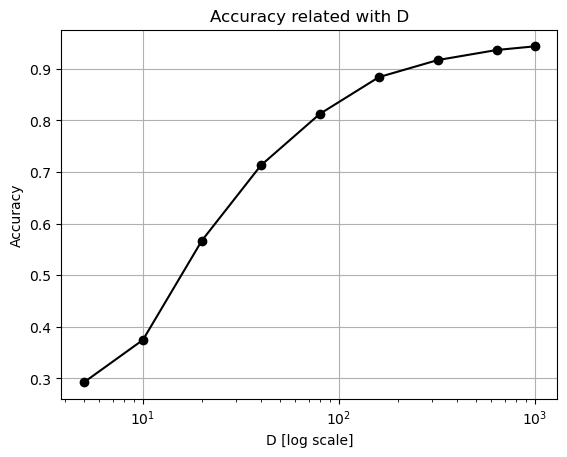

In [17]:
plt.plot(D_list, accuracy, '-ok')
plt.xscale("log")
plt.xlabel("D [log scale]")
plt.ylabel("Accuracy")
plt.title('Accuracy related with D')
plt.grid()
plt.show()

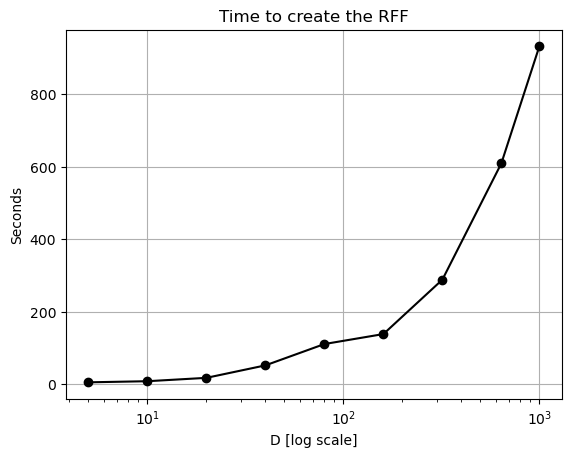

In [18]:
plt.plot(D_list,time_create, '-ok')
plt.xscale("log")
plt.xlabel("D [log scale]")
plt.ylabel("Seconds")
plt.title('Time to create the RFF')
plt.grid()
plt.show()

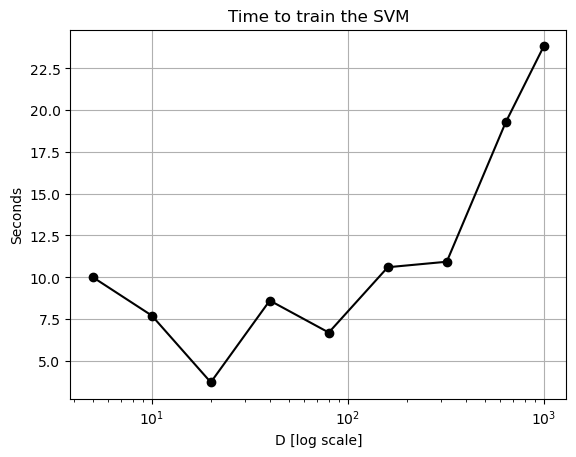

In [19]:
plt.plot(D_list,time_train, '-ok')
plt.xscale("log")
plt.xlabel("D [log scale]")
plt.ylabel("Seconds")
plt.title('Time to train the SVM')
plt.grid()
plt.show()

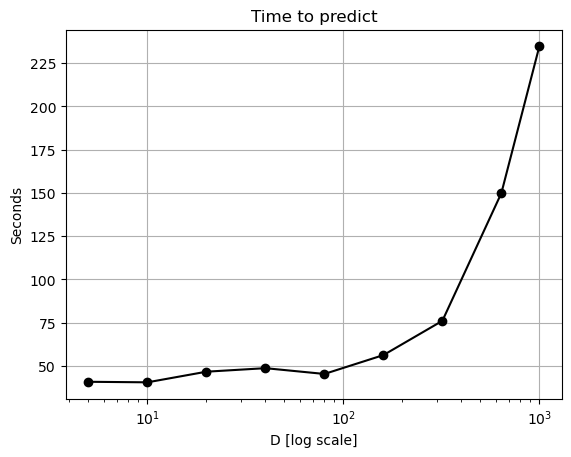

In [20]:
plt.plot(D_list,time_pred, '-ok')
plt.xscale("log")
plt.xlabel("D [log scale]")
plt.ylabel("Seconds")
plt.title('Time to predict')
plt.grid()
plt.show()

### Good luck =D